# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

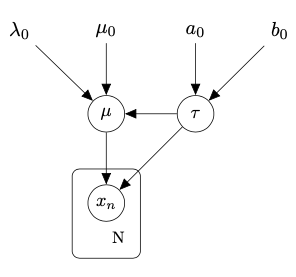

### ***Question 1.3.12:***

Implement a function that generates data points for the given model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:

def generate_data(mu, tau, N):
  # Insert your code here
  D = np.random.normal(mu, np.sqrt(1/tau), N)
  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



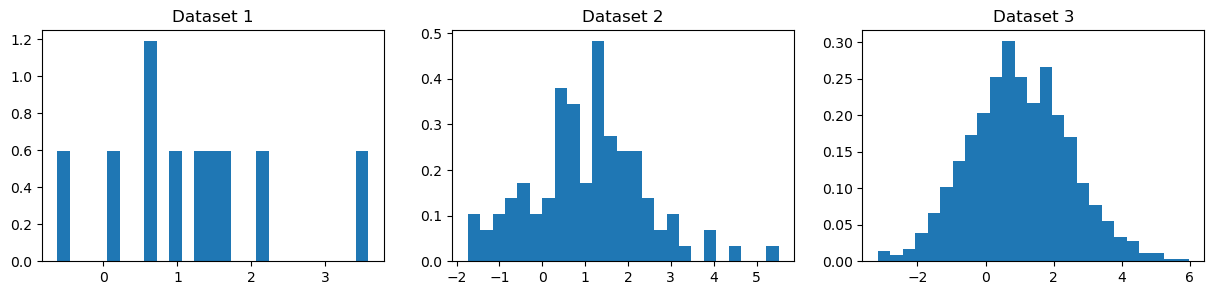

In [4]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
# Insert your code here
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))

ax1.set_title('Dataset 1')
A_bins = 25
ax1.hist(dataset_1,density=True,bins=A_bins)

ax2.set_title('Dataset 2')
B_bins = 25
ax2.hist(dataset_2,density=True,bins=B_bins)

ax3.set_title('Dataset 3')
C_bins = 25
ax3.hist(dataset_3,density=True,bins=C_bins)

plt.show()

### ***Question 1.3.13:***

Find ML estimates of the variables μ and τ

In [5]:
def ML_est(data):
  # insert your code
  mu_ml = np.mean(data)
  tau_ml = 1/np.power(np.std(data), 2)
  return mu_ml, tau_ml

datasets = [dataset_1, dataset_2, dataset_3]
for i , data in enumerate(datasets):
  mu_ml, tau_ml = ML_est(data)
  print(f"For dataset size {len(data)}:")
  print(f"  mu MLE: {mu_ml:.4f}")
  print(f"  tau MLE: {tau_ml:.4f}\n")

For dataset size 10:
  mu MLE: 1.2122
  tau MLE: 0.8228

For dataset size 100:
  mu MLE: 1.0664
  tau MLE: 0.5557

For dataset size 1000:
  mu MLE: 0.9925
  tau MLE: 0.4667



### ***Question 1.3.14:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [6]:
# prior parameters
mu_0 = 0
lambda_0 = 0
a_0 = 0
b_0 = 0

Continue with a helper function that computes ELBO:


In [7]:
from scipy.special import digamma, gammaln
from numpy import log, pi
def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  # given the prior and posterior parameters together with the data,
  # compute ELBO here
  N = D.size
  E_tau = a_N/b_N
  E_lntau = digamma(a_N) - log(b_N)
  E_u = mu_N
  E_u2 = mu_N**2+1/lambda_N

  # const terms are omited
  E1 = N/2 * E_lntau - 0.5 * E_tau * (np.sum(np.square(D)) - 2*E_u*np.sum(D) + N*E_u2)
  E2 = 0.5 * E_lntau - 0.5 * lambda_0 * E_tau * (E_u2 - 2*mu_0*E_u + mu_0**2)
  E3 = -b_0 * E_tau + (a_0-1) * E_lntau
  E4 = -0.5 * log(lambda_N)

  # use gammaln to avoid overflow
  E5 = -(a_N*log(b_N) - gammaln(a_N) - b_N*E_tau + (a_N-1)*E_lntau)
  

  elbo = E1 + E2 + E3 + E4 + E5
  return elbo


Now, implement the CAVI algorithm:

In [8]:
def update_q_mu(D, mu_0, lambda_0, E_tau):
    N = D.size
    mu_n = (lambda_0 * mu_0 + np.sum(D)) / (lambda_0 + N)
    lambda_n = (lambda_0 + N) * E_tau
    return mu_n, lambda_n

In [9]:
def update_q_tau(D, mu_0, lambda_0, a_0, b_0, E_u, E_u2):
    N = D.size
    a_n = N/2 + a_0 + 0.5
    b_n = b_0 + 0.5 * (np.sum(np.square(D)) + lambda_0 * np.square(mu_0)) - (lambda_0*mu_0+np.sum(D))*E_u + 0.5*(lambda_0+N)*E_u2
    return a_n, b_n

In [10]:
def CAVI(D, a_0, b_0, mu_0, lambda_0):
  # make an initial guess for the expected value of tau
  exp_tau = 100
  elbos = [1, 2]
  itrs = 0
  paras = [[mu_0, lambda_0, a_0, b_0]]
  #paras = []
  tolerance = 1e-6
  n = D.size

  while abs(elbos[-1] - elbos[-2]) > tolerance:
    itrs += 1
    mu_n, lambda_n = update_q_mu(D, mu_0, lambda_0, exp_tau)
    exp_u = mu_n
    exp_u2 = mu_n**2 + 1/lambda_n
    a_n, b_n = update_q_tau(D, mu_0, lambda_0, a_0, b_0, exp_u, exp_u2)
    exp_tau = a_n / b_n
    elbo = compute_elbo(D,a_0, b_0, mu_0, lambda_0, a_n , b_n, mu_n, lambda_n)
    elbos.append(elbo)
    paras.append([mu_n, (lambda_0+n)*a_n/b_n, a_n, b_n])
    print("iteration:", itrs, "ELBO:", elbo)

  # CAVI iterations ...
    # save ELBO for each iteration, plot them afterwards to show convergence

  return paras, elbos, itrs

### ***Question 1.3.15:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [11]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
  # your implementation
  n = D.size
  mu_r = (lambda_0 * mu_0 + np.sum(D)) / (lambda_0 + n)

  a_r = a_0 + 0.5 * (n + 1)
  b_r = b_0 + 0.5 * (lambda_0*mu_0**2+np.sum(np.square(D))-(lambda_0*mu_0+np.sum(D))**2/(lambda_0+n))

  tau_r = (lambda_0+n)*a_r/b_r

  exact_post_distribution = [mu_r, tau_r, a_r, b_r]
  return exact_post_distribution

### ***Question 1.3.16:***
Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.



iteration: 1 ELBO: -890.860432293132
iteration: 2 ELBO: -888.6749904259359
iteration: 3 ELBO: -888.6749901798273


Text(0, 0.5, 'ELBO')

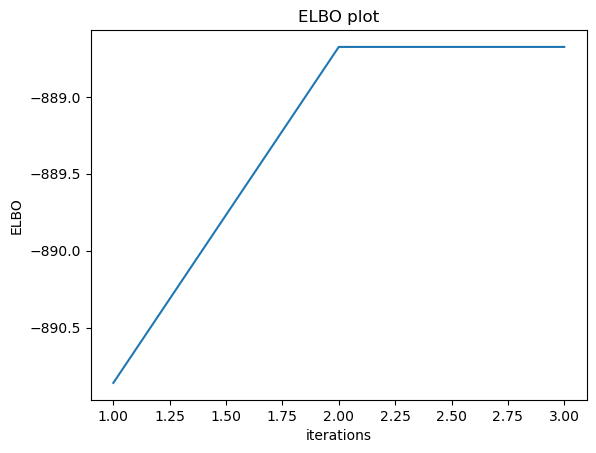

In [24]:
# Insert your main code here
mu_0 = 0
lambda_0 = 1
a_0 = 1
b_0 = 1
# Example flow for dataset_2:
ds = dataset_3
mu_ml, tau_ml = ML_est(ds)
paras, elbos, n_iter = CAVI(ds, a_0, b_0, mu_0, lambda_0)
elbos = elbos[2:]
# print(paras)
##  plot elbos, show convergence
plt.plot(list(range(1, n_iter+1)), elbos)
plt.title("ELBO plot")
plt.xlabel("iterations")
plt.ylabel("ELBO")

The parameters of exact posterior are:
μ=0.991515723429434, τ=467.8807855627335, α=501.5, β=1072.9260860674767

The parameters of CAVI posterior in iteration 0:
μ=0, τ=1, α=1, β=1

The parameters of CAVI posterior in iteration 1:
μ=0.991515723429434, τ=467.8786051767252, α=501.5, β=1072.9310860674768

The parameters of CAVI posterior in iteration 2:
μ=0.991515723429434, τ=467.4147666744992, α=501.5, β=1073.9958079877833

The parameters of CAVI posterior in iteration 3:
μ=0.991515723429434, τ=467.414304682265, α=501.5, β=1073.9968695250916



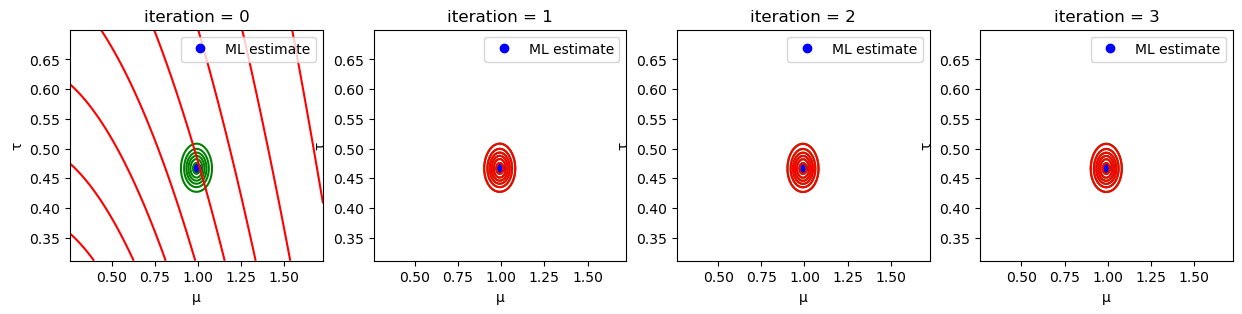

In [25]:
##  exact_post_dist = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot

from scipy.stats import gamma, norm

f, ax = plt.subplots(1, 4, figsize=(15, 3))
ax = [ax[0],ax[1],ax[2],ax[3]]
real_p = compute_exact_posterior(ds, a_0, b_0, mu_0, lambda_0)
print("The parameters of exact posterior are:")
print(f"μ={real_p[0]}, τ={real_p[1]}, α={real_p[2]}, β={real_p[3]}\n")

for i, axi in enumerate(ax):
    # ML point estimate
    
    axi.plot(mu_ml,tau_ml,'bo',label='ML estimate')
    axi.set_title('iteration = '+str(i))
    
    # contour plots of real posterior 
    mu_r, scale_r, a_r, b_r = real_p[0], np.sqrt(1/real_p[1]), real_p[2], real_p[3]
    mu_values = np.linspace(mu_ml - 0.5*np.std(ds), mu_ml + 0.5*np.std(ds), 1000)
    tau_values = np.linspace(1/(1.5 * np.var(ds)), 1.5 / np.var(ds), 1000)
    mu_grid, tau_grid = np.meshgrid(mu_values, tau_values)

    norm_r = norm.pdf(mu_grid, loc = mu_r, scale = scale_r)
    gamma_r = gamma.pdf(tau_grid, a = a_r, scale=1/b_r)
    axi.contour(mu_grid, tau_grid, norm_r * gamma_r, colors='green')

    # contour plots of CAVI results
    para = paras[i]
    print(f"The parameters of CAVI posterior in iteration {i}:")
    print(f"μ={para[0]}, τ={para[1]}, α={para[2]}, β={para[3]}\n")
    mu_i, scale_i, a_i, b_i = para[0], np.sqrt(1/para[1]), para[2], para[3]
    norm_i = norm.pdf(mu_grid, loc = mu_i, scale = scale_i)
    gamma_i = gamma.pdf(tau_grid, a = a_i, scale=1/b_i)
    axi.contour(mu_grid, tau_grid, norm_i * gamma_i, colors='red')

    axi.legend()
    axi.set_xlabel("μ")
    axi.set_ylabel("τ")

